In [3]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [4]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/03 12:49:19 WARN Utils: Your hostname, AATSurfacePro resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/03 12:49:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 12:49:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read the Parquet file into a Spark DataFrame
sdf = spark.read.parquet("../data/curated/prop_data_cleaned2.parquet")
sdf.printSchema()   

root
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

### Read in csv file and join them here (For now)

In [6]:
csv_df = spark.read.csv("../data/curated/postcode_data.csv", header=True, inferSchema=True)

csv_df = csv_df.withColumnRenamed("poa_code", "postal_code")

csv_df = csv_df.withColumn(
    "pop_percentage_increase", 
    (F.col("2023_pop") - F.col("2022_pop")) / F.col("2022_pop") * 100
)

# think income is by year so divide it by 52 to get weekly income 
csv_df = csv_df.select("median_inc", "2022_pop", "2023_pop", 'pop_percentage_increase', 'postal_code')

sdf = sdf.join(csv_df, on="postal_code", how="inner")

sdf.show()

24/10/03 12:49:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+--------------------+--------------------+----+-----+--------+----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------------+
|postal_code|                name|        property_url|beds|baths|parkings|cost|built_in_wardrobes|dishwasher|air_conditioning|floorboards|secure_parking|intercom|heating|ensuite|balcony_deck|gym|furnished|close_to_shops|close_to_transport|fully_fenced|close_to_schools|ducted_heating|split_system_heating|swimming_pool|remote_garage|balcony|study|garden_courtya

In [7]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

shape(sdf)

Shape of the DataFrame: 11131 rows, 44 columns.


In [8]:
sdf.columns

['postal_code',
 'name',
 'property_url',
 'beds',
 'baths',
 'parkings',
 'cost',
 'built_in_wardrobes',
 'dishwasher',
 'air_conditioning',
 'floorboards',
 'secure_parking',
 'intercom',
 'heating',
 'ensuite',
 'balcony_deck',
 'gym',
 'furnished',
 'close_to_shops',
 'close_to_transport',
 'fully_fenced',
 'close_to_schools',
 'ducted_heating',
 'split_system_heating',
 'swimming_pool',
 'remote_garage',
 'balcony',
 'study',
 'garden_courtyard',
 'pets_allowed',
 'internal_laundry',
 'alarm_system',
 'prop_type_index',
 'parks',
 'schools',
 'supermarkets',
 'hospitals',
 'shopping_districts',
 'CBD',
 'train_stations',
 'median_inc',
 '2022_pop',
 '2023_pop',
 'pop_percentage_increase']

In [9]:
# Select relevant features for the model
feature_columns = [
 'beds',
 'baths',
 'parkings',
 'postal_code',
#  'built_in_wardrobes',
#  'dishwasher',
#  'air_conditioning',
#  'floorboards',
#  'secure_parking',
#  'intercom',
#  'heating',
#  'ensuite',
#  'balcony_deck',
#  'gym',
#  'furnished',
#  'close_to_shops',
#  'close_to_transport',
#  'fully_fenced',
#  'close_to_schools',
#  'ducted_heating',
#  'split_system_heating',
#  'swimming_pool',
#  'remote_garage',
#  'balcony',
#  'study',
#  'garden_courtyard',
#  'pets_allowed',
#  'internal_laundry',
#  'alarm_system',
 'prop_type_index', 
 'median_inc', 
 '2023_pop',
 'pop_percentage_increase']
#  'parks',
#  'schools',
#  'supermarkets',
#  'hospitals',
#  'shopping_districts',
#  'CBD',
#  'train_stations']

In [10]:
# feature_columns = [
#     'beds', 'baths', 'parkings', 'prop_type_index',
#     'parks', 'schools', 'supermarkets', 'hospitals', 'shopping_districts', 'CBD', 'train_stations'
# ]

In [11]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *feature_columns)

data = assembler.transform(data)

data

cost,beds,baths,parkings,postal_code,prop_type_index,median_inc,2023_pop,pop_percentage_increase,features
825,3,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[3.0,1.0,1.0,3000..."
800,2,2,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[2.0,2.0,1.0,3000..."
760,2,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[2.0,1.0,1.0,3000..."
650,2,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[2.0,1.0,1.0,3000..."
550,1,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000..."
525,1,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000..."
525,2,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[2.0,1.0,1.0,3000..."
525,1,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000..."
480,1,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000..."
525,1,1,1,3000,0.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000..."


In [12]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

data = data.filter(F.col("cost") > 100)

In [13]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 12)
train_data

cost,beds,baths,parkings,postal_code,prop_type_index,median_inc,2023_pop,pop_percentage_increase,features,scaled_features
150,1,1,1,3000,1.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,1.0,3000...",[-1.4294748310660...
170,1,2,1,3161,1.0,64128.0,23932.0,3.772439510883705,"[1.0,2.0,1.0,3161...",[-1.4294748310660...
170,5,1,1,3175,1.0,47741.3798472149,13768.322569569264,2.824595201451548,"[5.0,1.0,1.0,3175...",[2.21994818374960...
175,1,1,1,3199,1.0,54312.83195480357,21284.981081168517,1.0434098576012032,"[1.0,1.0,1.0,3199...",[-1.4294748310660...
180,1,1,1,3073,1.0,53309.69295751158,13607.992541739284,2.858085499920821,"[1.0,1.0,1.0,3073...",[-1.4294748310660...
180,1,2,1,3915,1.0,52248.971329256354,13385.044237915701,-0.4465895731271954,"[1.0,2.0,1.0,3915...",[-1.4294748310660...
180,1,3,2,3083,1.0,49980.12486482208,9721.401459342282,5.531602779098316,"[1.0,3.0,2.0,3083...",[-1.4294748310660...
185,1,1,1,3012,1.0,56667.41975887043,15901.290411992599,3.154266670184265,"[1.0,1.0,1.0,3012...",[-1.4294748310660...
185,1,1,1,3175,3.0,47741.3798472149,13768.322569569264,2.824595201451548,"[1.0,1.0,1.0,3175...",[-1.4294748310660...
190,1,1,1,3011,0.0,54927.35101440222,18467.613593313396,9.358651532391772,"[1.0,1.0,1.0,3011...",[-1.4294748310660...


In [14]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/03 12:49:39 WARN Instrumentation: [4ab8c140] regParam is zero, which might cause numerical instability and overfitting.
24/10/03 12:49:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/03 12:49:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [15]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("Test RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 635.2833615534009
RMSE: 200.25025143084085
r2: 0.2734579068888846
Test RMSE:  201.02747758115564
Test r2:  0.2853598202937948


,feature,coefficient
1,baths,95.878794
0,beds,48.320634
5,median_inc,15.607654
2,parkings,-7.111508
6,2023_pop,-19.595910
7,pop_percentage_increase,-23.385356
4,prop_type_index,-23.484962
3,postal_code,-29.072264


In [16]:
# Initialize the Lasso Regression model
lasso = LinearRegression(featuresCol='features', labelCol='cost', elasticNetParam=0.5, regParam=0.1)

# Fit the model to the data
lasso_model = lasso.fit(train_data)

In [17]:
# Print model summary
print("Intercept: " + str(lasso_model.intercept))
print("RMSE: " + str(lasso_model.summary.rootMeanSquaredError))
print("r2: " + str(lasso_model.summary.r2))

# Get the coefficients and feature names
lasso_coefficients = lasso_model.coefficients.toArray()

# Create a DataFrame from the coefficients and feature names
lasso_coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso_coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
lasso_coefficients_df = lasso_coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
lasso_test_results = lasso_model.evaluate(test_data)

# Print evaluation metrics
print("Lasso Test RMSE: ", lasso_test_results.rootMeanSquaredError)
print("Lasso Test r2: ", lasso_test_results.r2)

lasso_coefficients_df

Intercept: 724.623527513408
RMSE: 200.2503415696991
r2: 0.2734572528104101
Lasso Test RMSE:  201.02053952809587
Lasso Test r2:  0.28540914813677254


,feature,coefficient
1,baths,154.465630
0,beds,43.952635
5,median_inc,0.001352
6,2023_pop,-0.004180
3,postal_code,-0.122068
7,pop_percentage_increase,-4.562865
2,parkings,-10.751229
4,prop_type_index,-27.413010


In [18]:
def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for the current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        
        # Drop the existing 'features' column if it exists
        if 'features' in data.columns:
            data = data.drop('features')

        # Transform the data to create the new 'features' column
        data_assembled = assembler.transform(data).select("features", label)
        
        # Create a StandardScaler instance
        scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
        
        # Fit the scaler to the data and transform it
        scaler_model = scaler.fit(data_assembled)
        data_scaled = scaler_model.transform(data_assembled)
        
        # Train the model on the scaled features
        lr = LinearRegression(featuresCol="scaled_features", labelCol=label)
        lr_model = lr.fit(data_scaled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient using absolute value
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break
    
    print(f"Final set of features: {features_to_keep}")
    return features_to_keep


In [19]:
# Perform backward elimination
final_features = backward_elimination(data, feature_columns, 'cost', stop_threshold=8.5)

Training model with 8 features.


24/10/03 12:49:48 WARN Instrumentation: [6b724641] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parkings
Training model with 7 features.


24/10/03 12:49:50 WARN Instrumentation: [65e2cf8b] regParam is zero, which might cause numerical instability and overfitting.


Final set of features: ['beds', 'baths', 'postal_code', 'prop_type_index', 'median_inc', '2023_pop', 'pop_percentage_increase']


In [20]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=final_features, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *feature_columns)
data = assembler.transform(data)

In [21]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [22]:
# Split the data into training and test sets
data = data.filter(F.col("cost") > 100)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=1003)
train_data

cost,beds,baths,parkings,postal_code,prop_type_index,median_inc,2023_pop,pop_percentage_increase,features,scaled_features
150,1,1,1,3000,1.0,38222.27067556402,18121.738315239138,15.243920141519387,"[1.0,1.0,3000.0,1...",[-1.4294748310660...
155,0,1,1,3199,3.0,54312.83195480357,21284.981081168517,1.0434098576012032,"[0.0,1.0,3199.0,3...",[-2.3418305847699...
170,1,2,1,3161,1.0,64128.0,23932.0,3.772439510883705,"[1.0,2.0,3161.0,1...",[-1.4294748310660...
170,5,1,1,3175,1.0,47741.3798472149,13768.322569569264,2.824595201451548,"[5.0,1.0,3175.0,1...",[2.21994818374960...
180,1,1,1,3073,1.0,53309.69295751158,13607.992541739284,2.858085499920821,"[1.0,1.0,3073.0,1...",[-1.4294748310660...
180,1,1,1,3128,1.0,41686.0,25286.0,6.11439842209073,"[1.0,1.0,3128.0,1...",[-1.4294748310660...
180,1,3,2,3083,1.0,49980.12486482208,9721.401459342282,5.531602779098316,"[1.0,3.0,3083.0,1...",[-1.4294748310660...
185,1,1,1,3175,3.0,47741.3798472149,13768.322569569264,2.824595201451548,"[1.0,1.0,3175.0,3...",[-1.4294748310660...
190,1,1,1,3175,0.0,47741.3798472149,13768.322569569264,2.824595201451548,"[1.0,1.0,3175.0,0...",[-1.4294748310660...
195,1,1,1,3021,1.0,43500.04742136532,17428.968756446273,1.5829147775152825,"[1.0,1.0,3021.0,1...",[-1.4294748310660...


In [23]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/03 12:49:53 WARN Instrumentation: [560ea21f] regParam is zero, which might cause numerical instability and overfitting.


In [24]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = final_features

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("Test RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 635.2587629881949
RMSE: 200.86265730562798
r2: 0.26706325122325114
Test RMSE:  199.6726739248657
Test r2:  0.29882096233081


,feature,coefficient
1,baths,94.035485
0,beds,42.316262
4,median_inc,17.616739
5,2023_pop,-18.645557
3,prop_type_index,-19.644949
6,pop_percentage_increase,-24.159262
2,postal_code,-27.158526


##### Diagnoistics of the LR Models 
With help of CHatgpt

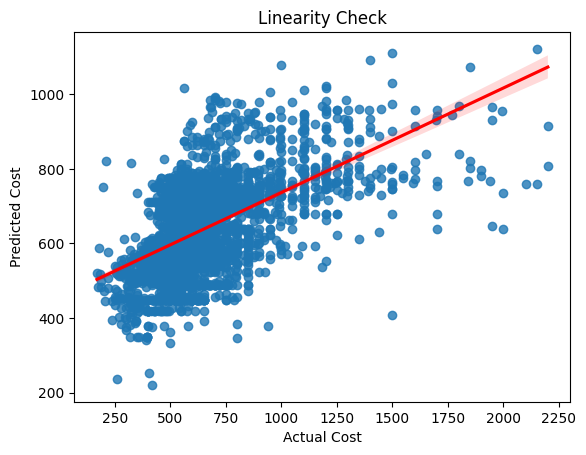

In [25]:
# Scatter plot for linearity check
# Get actual and predicted costs as Pandas DataFrames
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Combine the actual and predicted costs into a single DataFrame
comparison_df = actual_cost.copy()
comparison_df['predicted'] = predictions['prediction']

# Scatter plot for linearity check
sns.regplot(x='cost', y='predicted', data=comparison_df, line_kws={"color": "red"})
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Linearity Check')
plt.show()

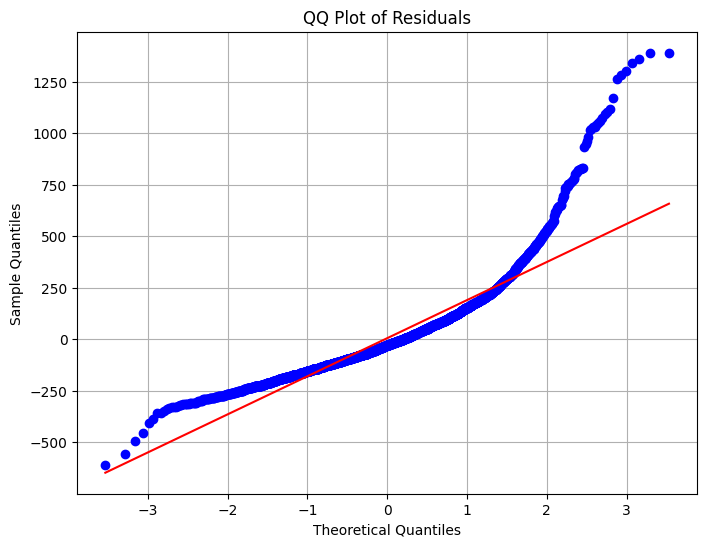

In [26]:
import scipy.stats as stats
# Step 1: Get actual and predicted costs
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')  
plt.grid()
plt.show()

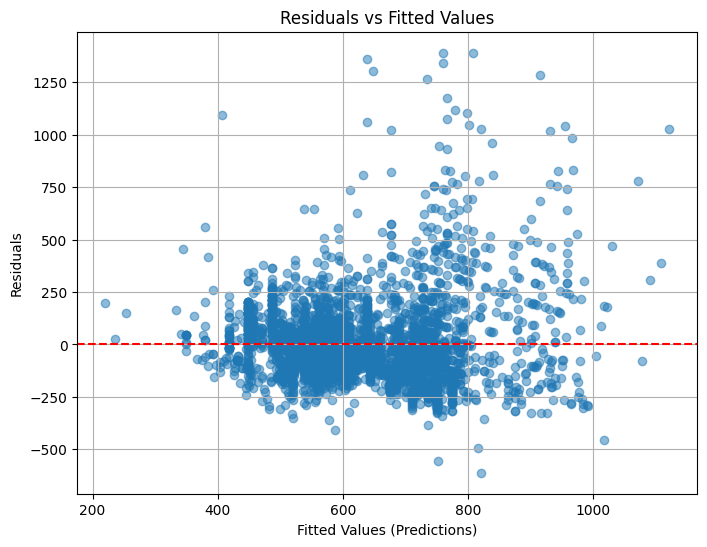

In [27]:
### Residuals vs fitted... 


actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions['prediction'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.grid()
plt.show()

## TREE MODELS

In [28]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Select the target variable (cost) and prepare the final DataFrame
data = sdf.select('cost', *feature_columns)

# Transform the features into a single vector column
data = assembler.transform(data)

# Create a MinMaxScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)

In [29]:
# Initialize the Gradient Boosting model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='cost', maxIter=40)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

In [30]:
# Print model summary
print("Gradient Boosting Model Summary")
print("Number of Trees: ", gbt_model.getNumTrees)

# Evaluate the model on the test data
gbt_predictions = gbt_model.transform(test_data)

# Create evaluators for RMSE, MAE, and R-squared
rmse_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="r2")

# Evaluate the model on the test data
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_mae = mae_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

# Print evaluation metrics
print(f"Gradient Boosting Test RMSE: {gbt_rmse}, MAE: {gbt_mae}, R2: {gbt_r2}")

Gradient Boosting Model Summary
Number of Trees:  40
Gradient Boosting Test RMSE: 138.88283340281941, MAE: 85.06709296531653, R2: 0.6663587087766817


In [31]:
# Get feature importances
gbt_feature_importances = gbt_model.featureImportances

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': gbt_feature_importances.toArray()
})

# Sort the DataFrame by the 'importance' column in decreasing order
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

,feature,importance
5,median_inc,0.201277
3,postal_code,0.173100
1,baths,0.160801
0,beds,0.158151
7,pop_percentage_increase,0.119933
6,2023_pop,0.106484
2,parkings,0.042066
4,prop_type_index,0.038189
